In [7]:
import kaggle
!kaggle competitions download -c spaceship-titanic



  0%|          | 0.00/299k [00:00<?, ?B/s]
100%|██████████| 299k/299k [00:00<00:00, 2.91MB/s]
100%|██████████| 299k/299k [00:00<00:00, 2.89MB/s]


In [1]:
import h2o
h2o.init()
trainRaw = h2o.import_file('train.csv')
testRaw = h2o.import_file('test.csv')

trainRaw.describe()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 23.0.2+7-58, mixed mode, sharing)
  Starting server from D:\Git\kaggle-spaceship-titanic\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kevin\AppData\Local\Temp\tmp9_nhw2lb
  JVM stdout: C:\Users\kevin\AppData\Local\Temp\tmp9_nhw2lb\h2o_kevin_started_from_python.out
  JVM stderr: C:\Users\kevin\AppData\Local\Temp\tmp9_nhw2lb\h2o_kevin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 19 days
H2O_cluster_name:,H2O_from_python_kevin_tz9cge
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.968 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:8693
Cols:14

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
type,string,enum,enum,enum,enum,int,enum,int,int,int,int,int,string,enum
mins,NaN,,,,,0.0,,0.0,0.0,0.0,0.0,0.0,NaN,
mean,NaN,,,,,28.82793046746535,,224.68761748120303,458.07720329024676,173.72916912197996,311.1387779083431,304.8547912992357,NaN,
maxs,NaN,,,,,79.0,,14327.0,29813.0,23492.0,22408.0,24133.0,NaN,
sigma,NaN,,,,,14.48902142390878,,666.7176629280652,1611.489240355072,604.6964584708243,1136.7055348344065,1145.7171888056614,NaN,
zeros,0,,,,,178,,5577,5456,5587,5324,5495,0,
missing,0,201,217,199,182,179,203,181,183,208,183,188,200,0
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [45]:
import pandas as pd
import numpy as np
trainRawDF = pd.read_csv('train.csv')
testRawDF = pd.read_csv('test.csv')
def curate(df):
    df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split('/', expand=True, n=3)
    df['CabinNumLen'] = df['CabinNum'].str.len()
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce').fillna(0)
    df['CabinRegion'] = pd.qcut(df['CabinNum'], q=7)
    df['AgeDecile'] = pd.qcut(df['Age'], q=10)

    df[['FirstName', 'LastName']] = df['Name'].str.split(' ', expand=True, n=2)
    familySize = df['LastName'].value_counts().reset_index().rename(columns={0:'count'})
    df['FamilySize'] = pd.merge(df, familySize, left_on='LastName', right_on='LastName', how='left')['count']

    df['GroupNum'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    groupSize =  df['GroupNum'].value_counts().reset_index().rename(columns={0:'count'})
    df['GroupSize'] = pd.merge(df, groupSize, left_on='GroupNum', right_on='GroupNum', how='left')['count']

    df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0, inplace=True)
    df['Expenditure'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df['LogExpenditure'] = np.log(df['Expenditure'] + 1)
    df['ZeroExpense'] = df['Expenditure'] == 0
    return df

trainProcessedDF = curate(trainRawDF)
testProcessedDF = curate(testRawDF)

print(trainProcessedDF.shape)
trainProcessedDF.describe()

(8693, 28)


C:\Users\kevin\AppData\Local\Temp\ipykernel_31040\2284470868.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0, inplace=True)
C:\Users\kevin\AppData\Local\Temp\ipykernel_31040\2284470868.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0, inplace=True)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNum,CabinNumLen,FamilySize,GroupNum,GroupSize,Expenditure,LogExpenditure
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8494.000000,8493.000000,8693.000000,8693.000000,7785.000000,7785.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,586.624065,3.077584,5.428117,4633.389624,2.035546,1484.601541,4.305709
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,513.880084,0.668008,2.891901,2671.028856,1.596347,2845.288241,3.700501
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,3.000000,3.000000,2319.000000,1.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,3.000000,5.000000,4630.000000,1.000000,736.000000,6.602588
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,983.000000,3.000000,7.000000,6883.000000,3.000000,1486.000000,7.304516
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000,4.000000,18.000000,9280.000000,8.000000,35987.000000,10.490941


In [21]:
corr_matrix = trainProcessedDF[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].corr()
print(corr_matrix)
print(trainProcessedDF.nunique())
print(trainProcessedDF.dtypes)
print(trainProcessedDF.head())

              RoomService  FoodCourt  ShoppingMall       Spa    VRDeck
RoomService      1.000000  -0.015889      0.054480  0.010080 -0.019581
FoodCourt       -0.015889   1.000000     -0.014228  0.221891  0.227995
ShoppingMall     0.054480  -0.014228      1.000000  0.013879 -0.007322
Spa              0.010080   0.221891      0.013879  1.000000  0.153821
VRDeck          -0.019581   0.227995     -0.007322  0.153821  1.000000
PassengerId       8693
HomePlanet           3
CryoSleep            2
Cabin             6560
Destination          3
Age                 80
VIP                  2
RoomService       1273
FoodCourt         1507
ShoppingMall      1115
Spa               1327
VRDeck            1306
Name              8473
Transported          2
Deck                 8
Num               1817
Side                 2
NumLen               4
NumDecile           10
FirstName         2706
LastName          2217
FamilySize          17
GroupNum          6217
GroupSize            8
Expenditure       2116

In [2]:
import altair as alt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


In [ ]:
def numericScatterPlots(df, numericList, colorLabel):
    comboList = []
    for i in range(len(numericList)):
        for j in range(i+1, len(numericList)):
            comboList.append((numericList[i], numericList[j]))

    numCombos = len(comboList)

    fig=plt.figure(figsize=(10,numCombos*4))
    for i, (x, y) in enumerate(comboList):
        ax=fig.add_subplot(numCombos,1,i+1)
        sns.scatterplot(data=df, x=x, y=y, hue=colorLabel)
        ax.set_title(f'{x} vs {y}') 
    fig.tight_layout()

def categoricalCountPlots(df, categoricalList, colorLabel):
    numFeats = len(categoricalList)
    fig=plt.figure(figsize=(10,numFeats*4))
    for i, var_name in enumerate(categoricalList):
        ax=fig.add_subplot(numFeats,1,i+1)
        sns.countplot(data=df, x=var_name, axes=ax, hue=colorLabel)
        ax.set_title(var_name) 
    fig.tight_layout()

d:\Git\kaggle-spaceship-titanic\src


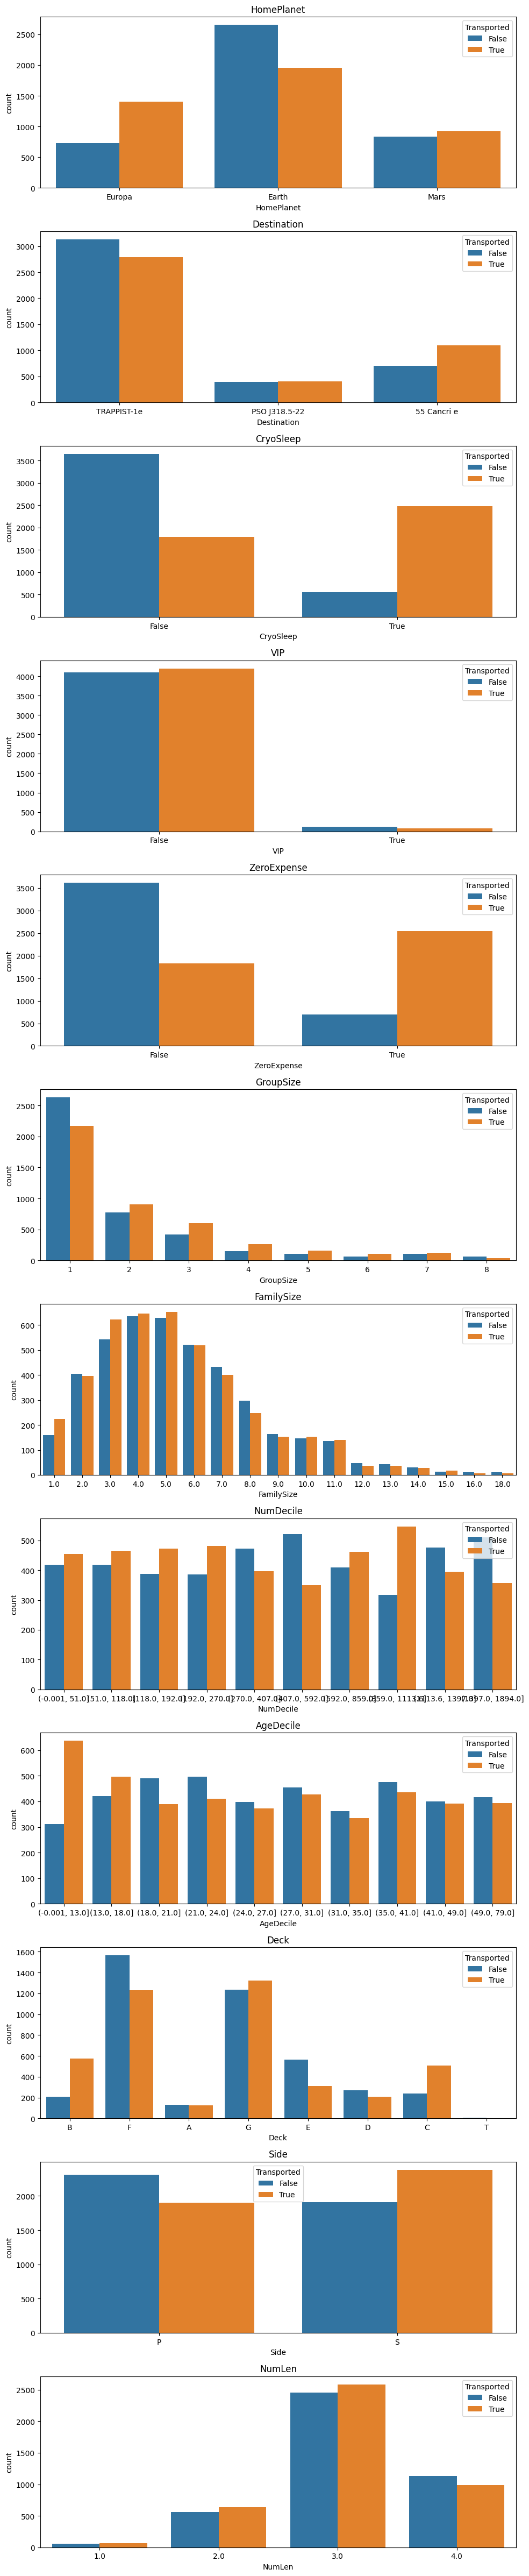

In [8]:
import sys
import os
wd = os.getcwd()
print(wd)
sys.path.insert(0, wd)
                
import plotHelper as ph
categoricalList=['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'ZeroExpense', 'GroupSize', 'FamilySize']
categoricalList.extend(['NumDecile', 'AgeDecile', 'Deck','Side', 'NumLen']) # Cabin derived features
categoricalCountPlots(trainProcessedDF, categoricalList, 'Transported')

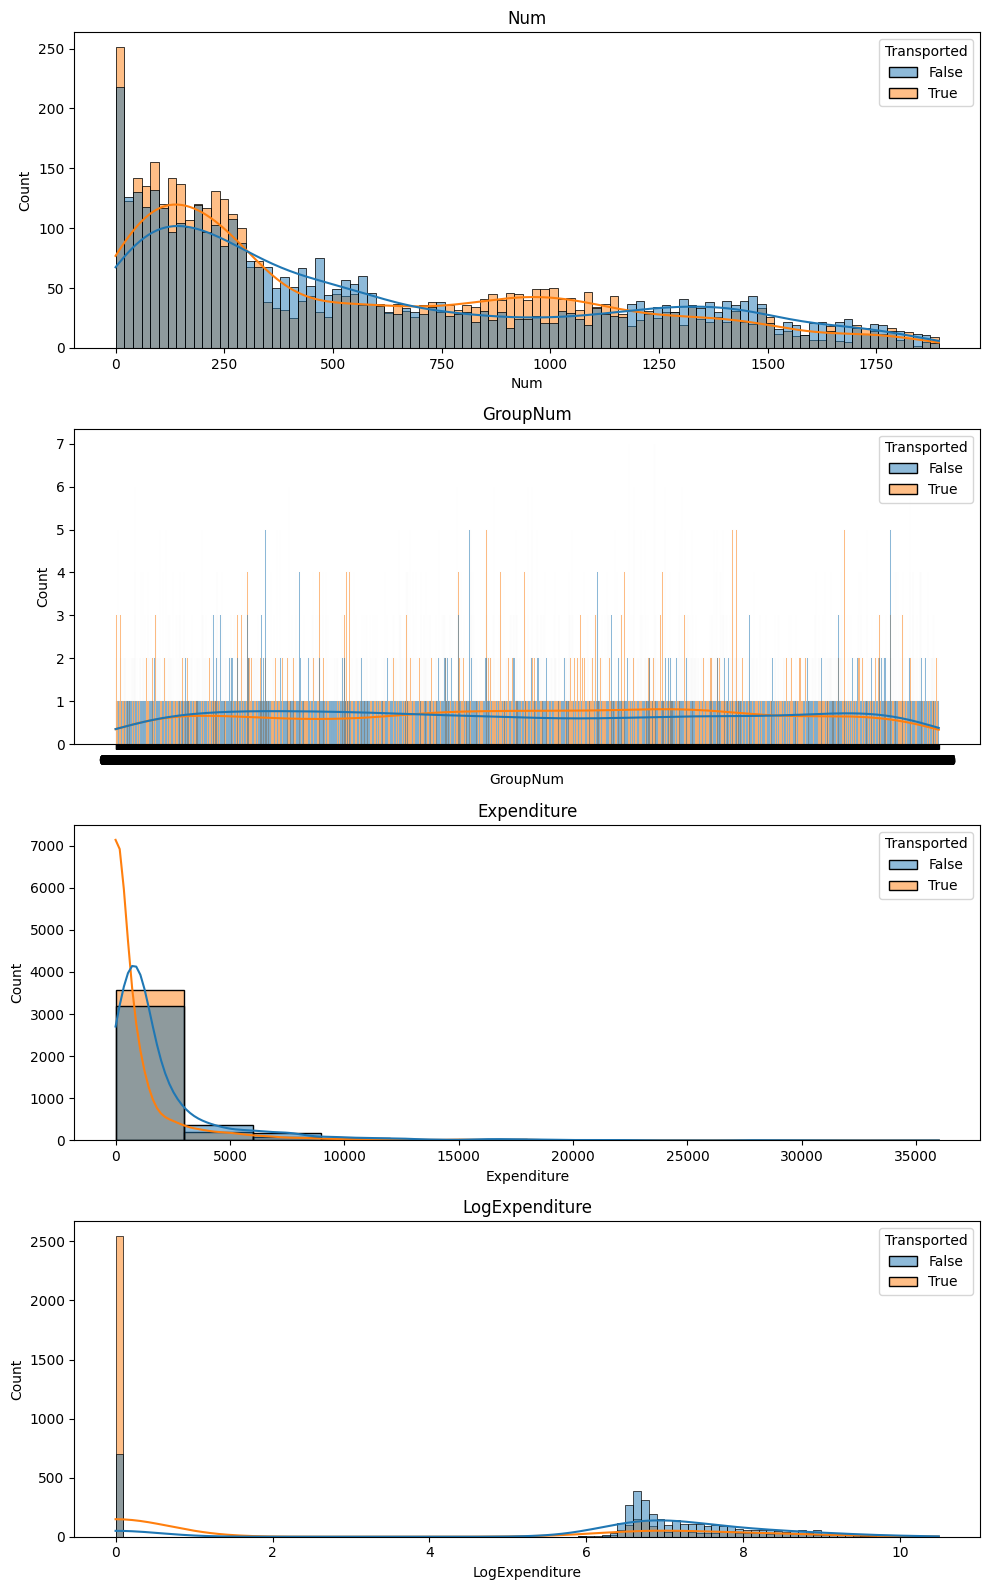

In [ ]:
numerics=['CabinNum', 'GroupNum', 'Expenditure', 'LogExpenditure', 'Age']
numericTuples=[('CabinNum', 20), ('GroupNum', 200), ('Expenditure',3000), ('LogExpenditure', 0.1), ('Age', 1)]

def numericHistograms(df, numericList, colorLabel):
    numNumerics = len(numericList)
    fig=plt.figure(figsize=(10,numNumerics*4))
    for i, (numeric, bw) in enumerate(numericList):
        ax=fig.add_subplot(numNumerics,1,i+1)
        sns.histplot(data=df, x=numeric, hue=colorLabel, binwidth=bw, kde=True)
        ax.set_title(numeric) 
    fig.tight_layout()
numericHistograms(trainProcessedDF, numericTuples, 'Transported')

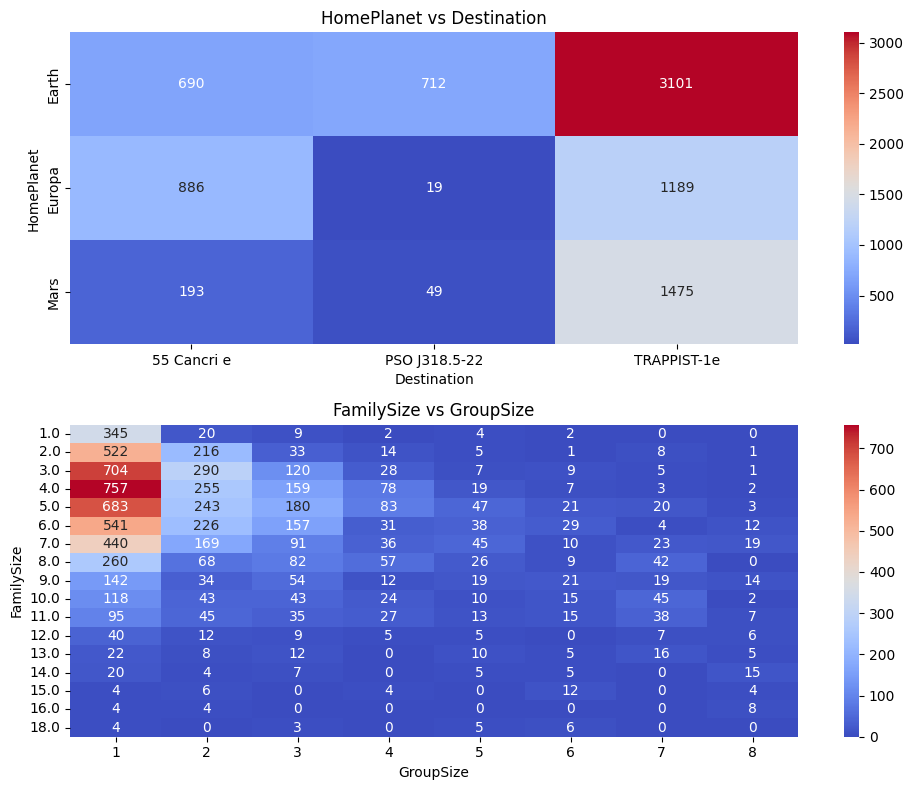

In [95]:
def catCombo_Heatmap(df, comboList):
    numCombos = len(comboList)
    fig=plt.figure(figsize=(10,numCombos*4))
    for i, (x, y) in enumerate(comboList):
        gbdf=df.groupby([y, x])[x].size().unstack().fillna(0)
        ax=fig.add_subplot(numCombos,1,i+1)
        sns.heatmap(gbdf.T, annot=True, fmt='g', cmap='coolwarm')
        ax.set_title(f'{x} vs {y}') 
    fig.tight_layout()

combos = [('HomePlanet', 'Destination'), ('FamilySize', 'GroupSize')]
catCombo_Heatmap(trainProcessedDF, combos)

In [ ]:
filteredDF = trainProcessedDF[trainProcessedDF['GroupSize'] > 1]

('GroupNum', 'Deck') -> (1412,)
('GroupNum', 'CabinNum') -> (1412,)
('GroupNum', 'Side') -> (1412,)
('GroupNum', 'HomePlanet') -> (1411,)
('GroupNum', 'Destination') -> (1412,)
('GroupNum', 'CryoSleep') -> (1411,)


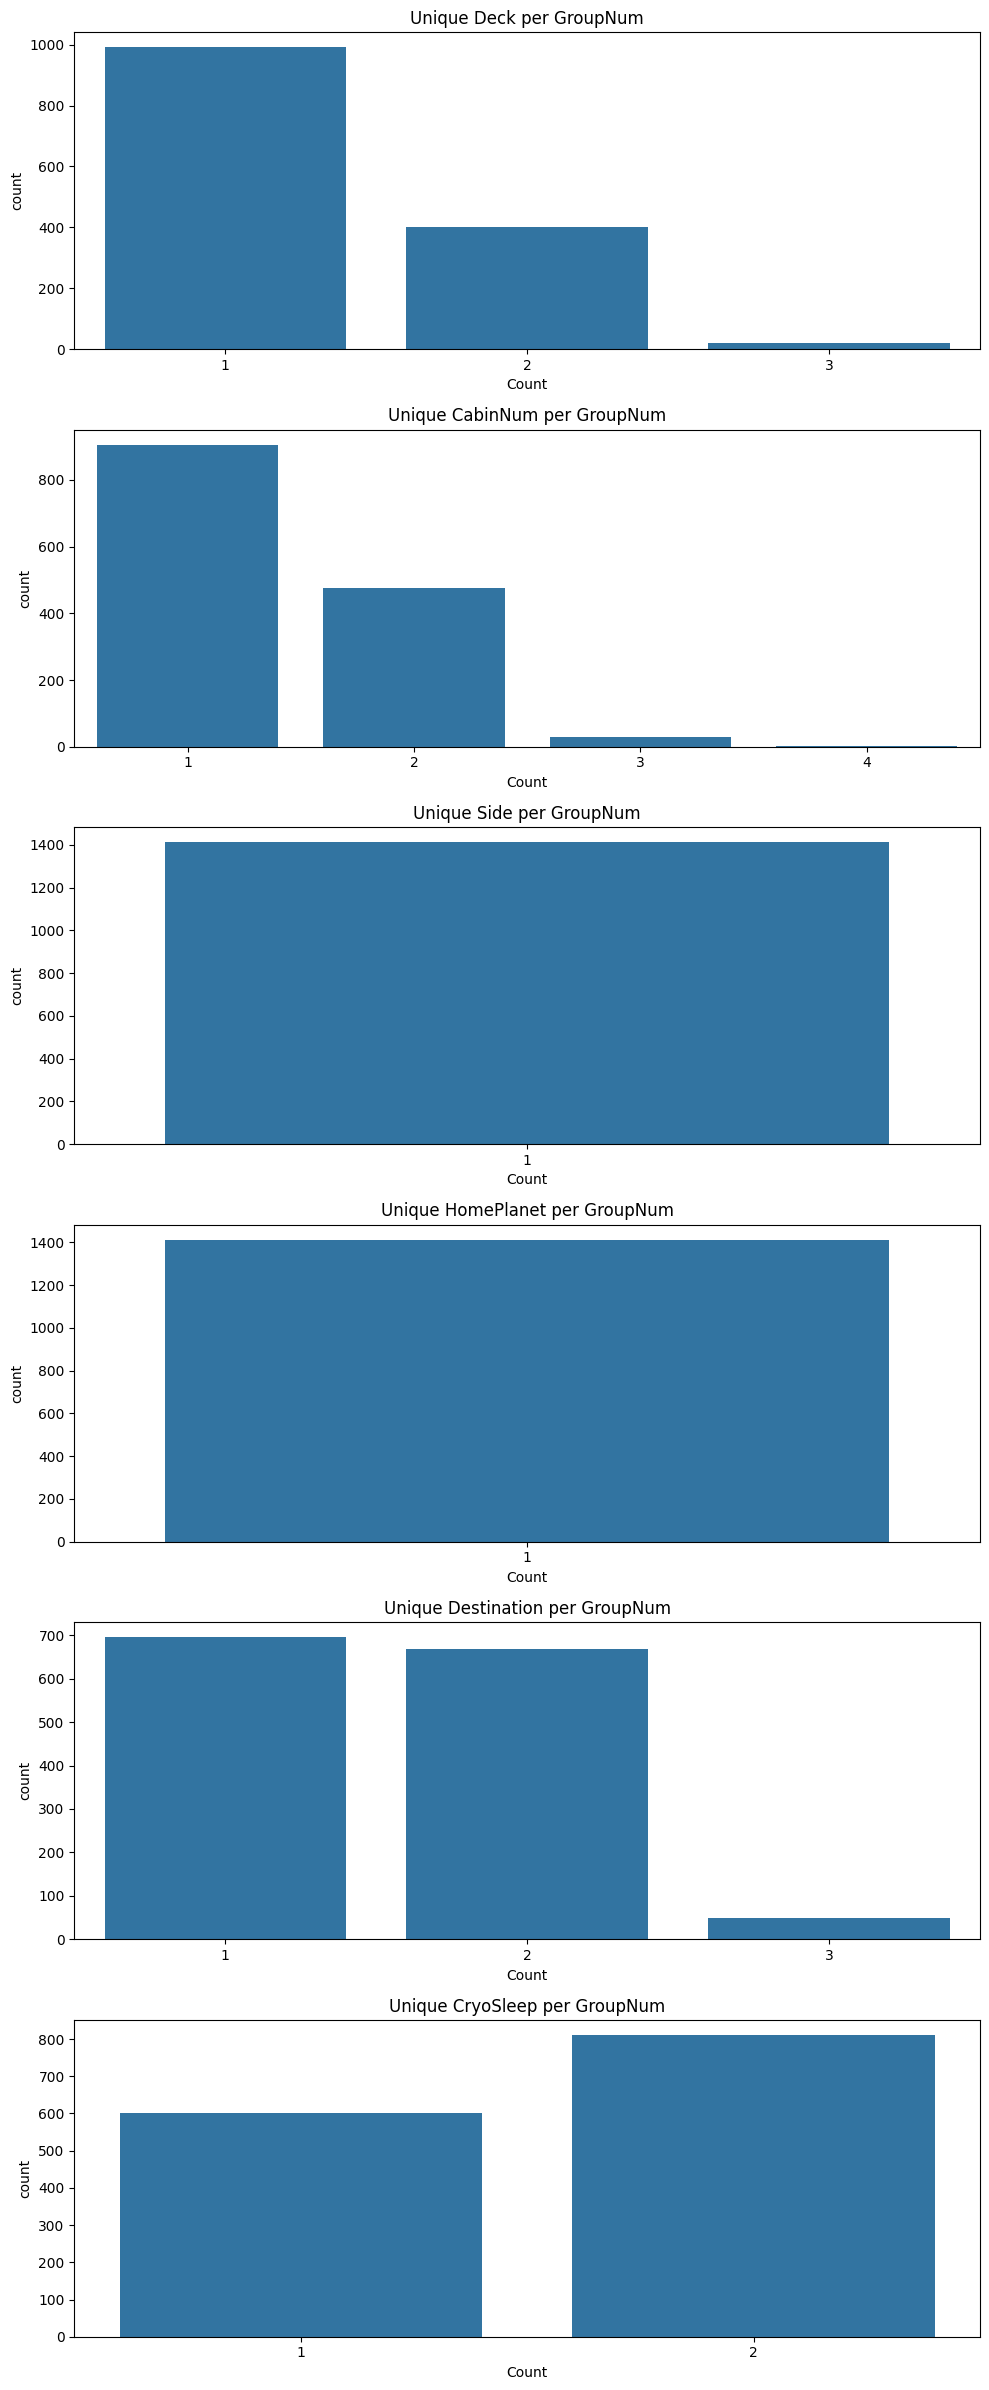

In [102]:
def catCombo_GbCountplot(df, comboList):
    dfDict = {}
    for tpl in comboList:
        (y,x) = tpl
        catCountDF = df.groupby([y, x])[x].size().unstack().fillna(0)
        uniqueSeries = (catCountDF>0).sum(axis=1).reset_index(name='Count')['Count'].sort_values().astype(str)
        dfDict[tpl] = uniqueSeries
    numCombos = len(comboList)

    for tpl, df in dfDict.items():
        print(f"{tpl} -> {df.shape}")

    fig=plt.figure(figsize=(10,numCombos*4))
    for i, (tpl, dfgb) in enumerate(dfDict.items()):
        (x,y) = tpl
        ax=fig.add_subplot(numCombos,1,i+1)
        sns.countplot(x=dfgb)
        ax.set_title(f"Unique {y} per {x}")
    fig.tight_layout()

combos = [('GroupNum','Deck'), ('GroupNum', 'CabinNum'), ('GroupNum', 'Side'), ('GroupNum', 'HomePlanet'), ('GroupNum', 'Destination'), ('GroupNum', 'CryoSleep')]
filteredDF = trainProcessedDF[trainProcessedDF['GroupSize'] > 1]
catCombo_GbCountplot(filteredDF, combos)

Conclusions:
* 

('LastName', 'Deck') -> (1835,)
('LastName', 'CabinNum') -> (1835,)
('LastName', 'Side') -> (1835,)
('LastName', 'HomePlanet') -> (1835,)
('LastName', 'Destination') -> (1835,)
('LastName', 'CryoSleep') -> (1835,)


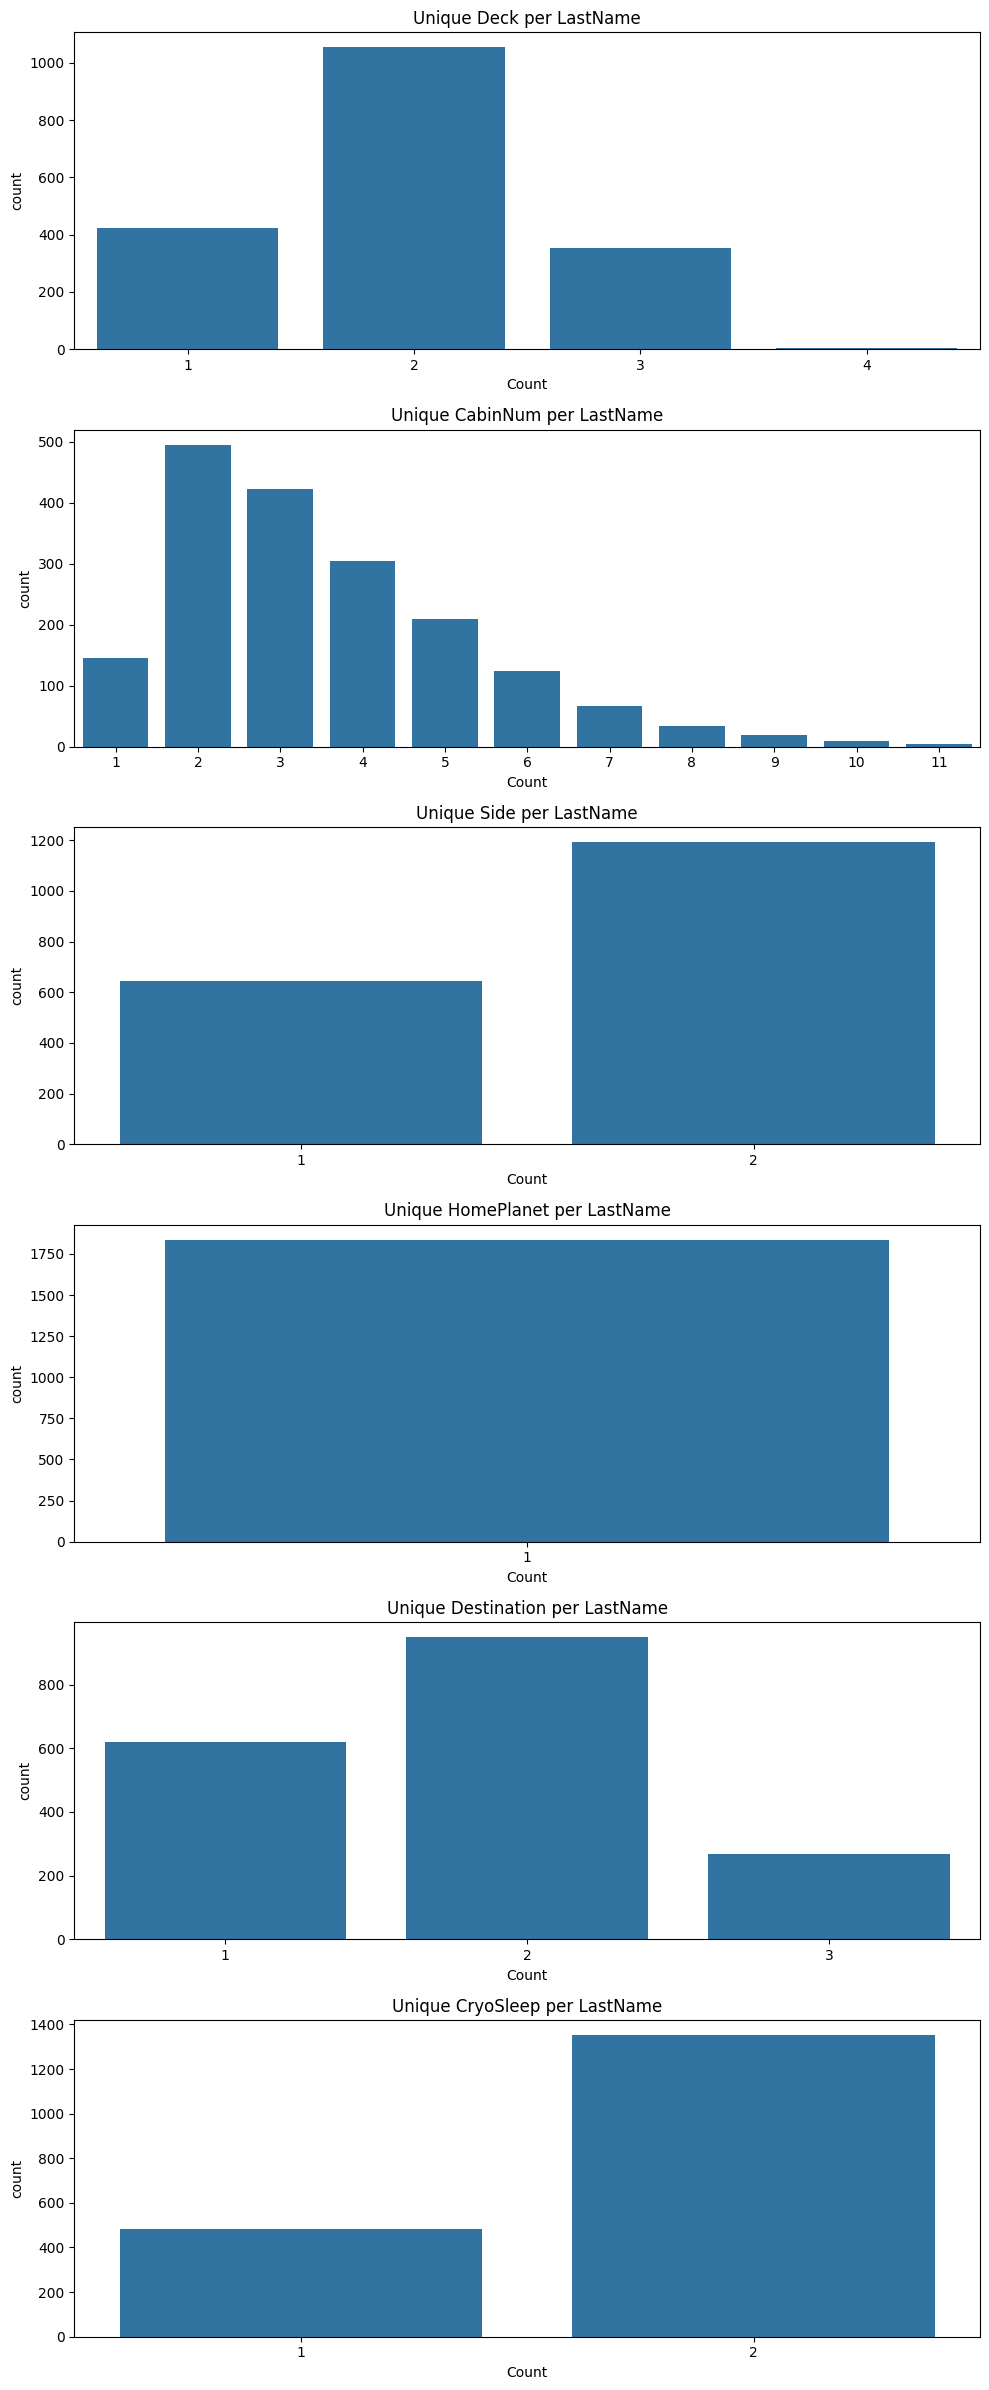

In [104]:
combos = [('LastName','Deck'), ('LastName', 'CabinNum'), ('LastName', 'Side'), ('LastName', 'HomePlanet'), ('LastName', 'Destination'), ('LastName', 'CryoSleep')]
filteredDF = trainProcessedDF[trainProcessedDF['FamilySize'] > 1]
catCombo_GbCountplot(filteredDF, combos)

In [ ]:
import pygwalker as pyg
pyg.walk(trainProcessedDF)

In [ ]:
import h2o
h2o.init()

trainHF = h2o.H2OFrame(trainProcessedDF)
testHF = h2o.H2OFrame(testProcessedDF)

trainHF.describe()
x = trainHF.columns
y = "Transported"
trainHF[y] = trainHF[y].asfactor()
x.remove(y)


from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models=10, seed=42, max_runtime_secs=7200, sort_metric='accuracy')
aml.train(x=x, y=y, training_frame=trainHF)
print(aml.leaderboard)

# Raw: Accuracy 79.1 - 80.1%
# Curated: Accuracy 79.4 - 80.9%

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 23.0.2+7-58, mixed mode, sharing)
  Starting server from D:\Git\kaggle-spaceship-titanic\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kevin\AppData\Local\Temp\tmpmczpjdu2
  JVM stdout: C:\Users\kevin\AppData\Local\Temp\tmpmczpjdu2\h2o_kevin_started_from_python.out
  JVM stderr: C:\Users\kevin\AppData\Local\Temp\tmpmczpjdu2\h2o_kevin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 19 days
H2O_cluster_name:,H2O_from_python_kevin_7hwon9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.968 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:8693
Cols:25

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,FirstName,LastName,FamilySize,GroupNum,GroupSize,Expenditure,LogExpenditure,ZeroExpense
type,string,enum,enum,enum,enum,int,enum,int,int,int,int,int,string,enum,enum,int,enum,enum,enum,int,int,int,int,real,enum
mins,NaN,,,,,0.0,,0.0,0.0,0.0,0.0,0.0,NaN,,,0.0,,,,1.0,1.0,1.0,0.0,0.0,
mean,NaN,,,,,28.827930467465404,,224.6876174812026,458.0772032902469,173.72916912197988,311.1387779083443,304.85479129923556,NaN,,,600.3676712973853,,,,5.428117273048399,4633.389623835275,2.035545841481651,1484.6015414258181,4.305709176527687,
maxs,NaN,,,,,79.0,,14327.0,29813.0,23492.0,22408.0,24133.0,NaN,,,1894.0,,,,18.0,9280.0,8.0,35987.0,10.49094082853701,
sigma,NaN,,,,,14.489021423908754,,666.7176629280646,1611.4892403550716,604.6964584708244,1136.7055348344063,1145.7171888056605,NaN,,,511.86722602437817,,,,2.891900867233574,2671.0288558525617,1.5963465080727197,2845.28824074406,3.7005013239040574,
zeros,0,,,,,178,,5577,5456,5587,5324,5495,0,,,18,,,,0,0,0,3247,3247,
missing,0,0,0,0,0,179,0,181,183,208,183,188,0,0,0,199,0,0,0,200,0,0,908,908,0
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,Maham,Ofracculy,1.0,1.0,1.0,0.0,0.0,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,Juanna,Vines,4.0,2.0,1.0,736.0,6.602587892189336,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,Altark,Susent,6.0,3.0,2.0,10383.0,9.248021438943873,False


AutoML progress: |
14:13:21.194: AutoML: XGBoost is not available; skipping it.
14:13:21.265: _train param, Dropping bad and constant columns: [PassengerId, Name]

████
14:13:26.422: _train param, Dropping bad and constant columns: [PassengerId, Name]


14:13:35.45: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
14:13:46.79: _train param, Dropping bad and constant columns: [PassengerId, Name]


14:13:50.107: _train param, Dropping bad and constant columns: [PassengerId, Name]

██
14:13:54.992: _train param, Dropping bad and constant columns: [PassengerId, Name]

██
14:14:02.90: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
14:14:20.166: _train param, Dropping bad and constant columns: [PassengerId, Name]

█
14:14:23.517: _train param, Dropping bad and constant columns: [PassengerId, Name]

███
14:14:44.163: _train param, Dropping unused columns: [PassengerId, Name]

█████████
14:14:46.862: _train param, Dropping unused columns: [Pa

                      variable  relative_importance  scaled_importance  \
0                          Spa             1.000000           1.000000   
1                       VRDeck             0.935260           0.935260   
2               CryoSleep.True             0.858905           0.858905   
3                  RoomService             0.541771           0.541771   
4                       Deck.C             0.525849           0.525849   
...                        ...                  ...                ...   
11531   HomePlanet.missing(NA)             0.000000           0.000000   
11532         Side.missing(NA)             0.000000           0.000000   
11533          VIP.missing(NA)             0.000000           0.000000   
11534    CryoSleep.missing(NA)             0.000000           0.000000   
11535  ZeroExpense.missing(NA)             0.000000           0.000000   

       percentage  
0        0.001533  
1        0.001434  
2        0.001317  
3        0.000831  
4        0.

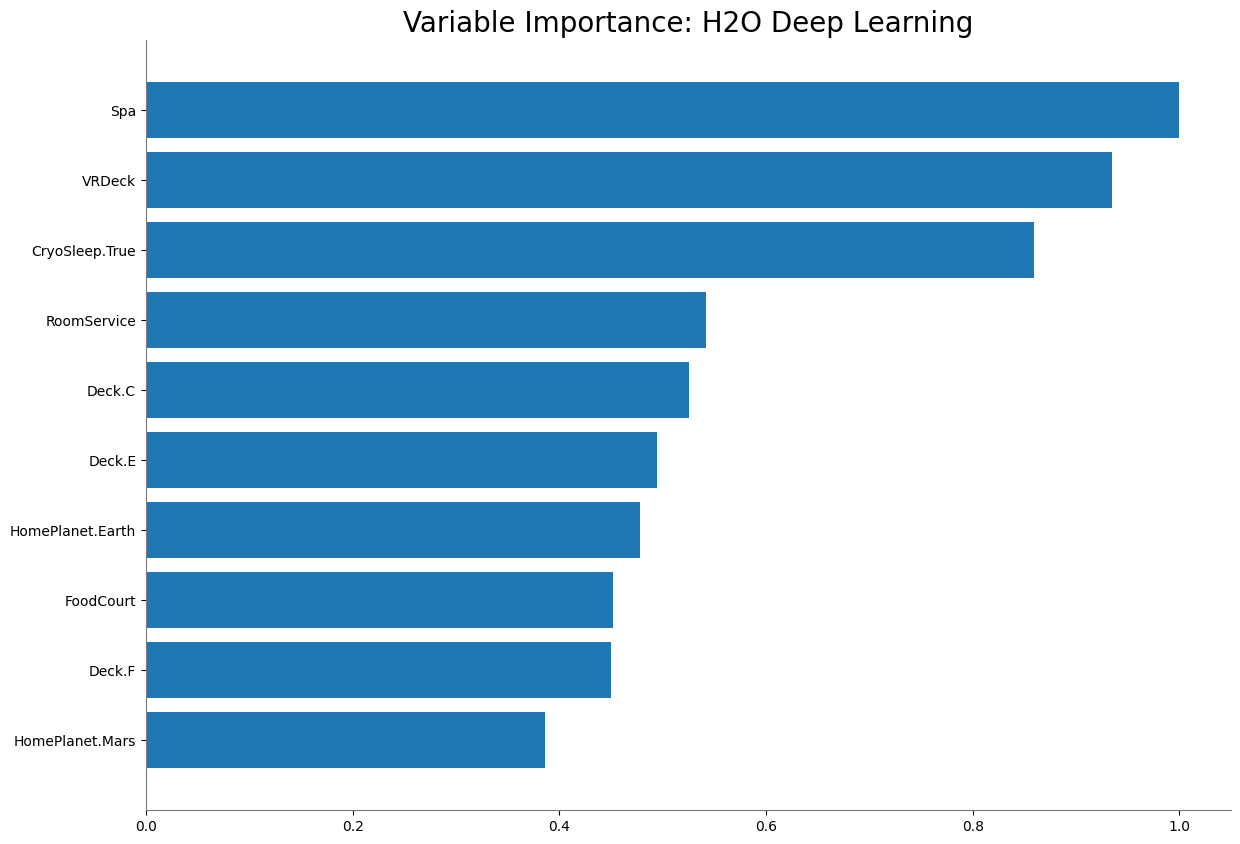

<Figure size 640x480 with 0 Axes>

In [11]:
print(aml.leader.varimp(use_pandas=True))
aml.leader.varimp_plot()

In [32]:
test = curate(pd.read_csv('test.csv'))
test = h2o.H2OFrame(test)
test.describe()
preds = aml.leader.predict(test)
preds.describe()
fullPredsHF = test.cbind(preds)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:4277
Cols:18

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinOne,CabinTwo,CabinThree,First Name,Last Name
type,string,enum,enum,enum,enum,int,enum,int,int,int,int,int,string,enum,int,enum,enum,enum
mins,NaN,,,,,0.0,,0.0,0.0,0.0,0.0,0.0,NaN,,0.0,,,
mean,NaN,,,,,28.65814620162445,,219.26626936829544,439.48429633181445,177.2955252452741,303.0524425287358,310.7100309745055,NaN,,610.1788364855154,,,
maxs,NaN,,,,,79.0,,11567.0,25273.0,8292.0,19844.0,22272.0,NaN,,1890.0,,,
sigma,NaN,,,,,14.179071585227367,,607.0112887875927,1527.6630449251825,560.8211231958647,1117.186014940959,1246.9947416212317,NaN,,514.9681306884872,,,
zeros,0,,,,,82,,2726,2690,2744,2611,2757,0,,7,,,
missing,0,0,0,0,0,91,0,82,106,98,101,80,0,0,100,0,0,0
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3.0,S,Nelly,Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4.0,S,Lerome,Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0.0,S,Sabih,Unhearfus


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


d:\Git\kaggle-spaceship-titanic\.venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset column 'Cabin' has levels not trained on: ["A/1/P", "A/105/S", "A/108/S", "A/109/S", "A/11/P", "A/12/P", "A/12/S", "A/13/S", "A/15/P", "A/15/S", ...3245 not listed..., "G/993/P", "G/994/P", "G/995/P", "G/996/P", "G/997/P", "G/997/S", "T/0/S", "T/1/S", "T/3/S", "T/4/P"]
  warnings.warn(w)
d:\Git\kaggle-spaceship-titanic\.venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset column 'First Name' has levels not trained on: ["Achirk", "Acrabi", "Acruxa", "Aldush", "Alebix", "Alinan", "Alk", "Alnath", "Alphain", "Alraino", ...157 not listed..., "Unukat", "Volath", "Wark", "Weer", "Wer", "Wheets", "Yildunt", "Zibaham", "Zosmar", "Zubens"]
  warnings.warn(w)
d:\Git\kaggle-spaceship-titanic\.venv\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset column 'Last Name' has levels not trained on: ["Aginoid", "Aloquinght", "Alutorody", "Anate", "Apity", "

Rows:4277
Cols:3

,predict,False,True
type,enum,real,real
mins,,4.44144929845347e-06,1.2094850217788862e-14
mean,,0.5014004306425283,0.49859956935747135
maxs,,0.9999999999999879,0.9999955585507015
sigma,,0.3245797487066522,0.3245797487066521
zeros,,0,0
missing,0,0,0
0,True,0.27480449677359264,0.7251955032264074
1,False,0.993853826058361,0.006146173941639013
2,True,0.012080074074453773,0.9879199259255462


In [37]:
fullPredsDF = fullPredsHF.as_data_frame()
fullPredsDF = fullPredsDF[['PassengerId', 'predict']]
fullPredsDF = fullPredsDF.rename(columns={'predict': 'Transported'})
fullPredsDF.to_csv('submission.csv', index=False)

d:\Git\kaggle-spaceship-titanic\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [38]:
!kaggle competitions submit -c spaceship-titanic -f submission.csv -m "First Pass with H2O"

Successfully submitted to Spaceship Titanic



  0%|          | 0.00/60.3k [00:00<?, ?B/s]
100%|██████████| 60.3k/60.3k [00:00<00:00, 81.1kB/s]
